In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller,kpss
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import xgboost as xgb

In [113]:
df_sample = pd.read_csv('sample_9.csv')

In [114]:
df_sample.rename(columns={'Unnamed: 0':'index'}, inplace=True)
df_sample.head()

,index,point_timestamp,point_value
0,0,1997-01-01,3.45
1,1,1997-02-01,2.15
2,2,1997-03-01,1.89
3,3,1997-04-01,2.03
4,4,1997-05-01,2.25


In [115]:
df_sample = df_sample.drop('index', axis=1)
df_sample.head()

,point_timestamp,point_value
0,1997-01-01,3.45
1,1997-02-01,2.15
2,1997-03-01,1.89
3,1997-04-01,2.03
4,1997-05-01,2.25


In [116]:
#removing null values
df_sample.dropna(axis = 0, inplace = True)
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 291 entries, 0 to 290
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   point_timestamp  291 non-null    object 
 1   point_value      291 non-null    float64
dtypes: float64(1), object(1)
memory usage: 4.7+ KB


In [117]:
#removing duplicates
df_sample.drop_duplicates(subset="point_value", inplace=True)
df_sample.shape

(221, 2)

In [99]:
#df_sample['date'] = pd.to_datetime(df_sample.date)
df_sample.set_index('point_timestamp',inplace=True)
df_sample.head(5)

,point_value
point_timestamp,
1997-01-01,3.45
1997-02-01,2.15
1997-03-01,1.89
1997-04-01,2.03
1997-05-01,2.25


Text(0.5, 0, 'Time')

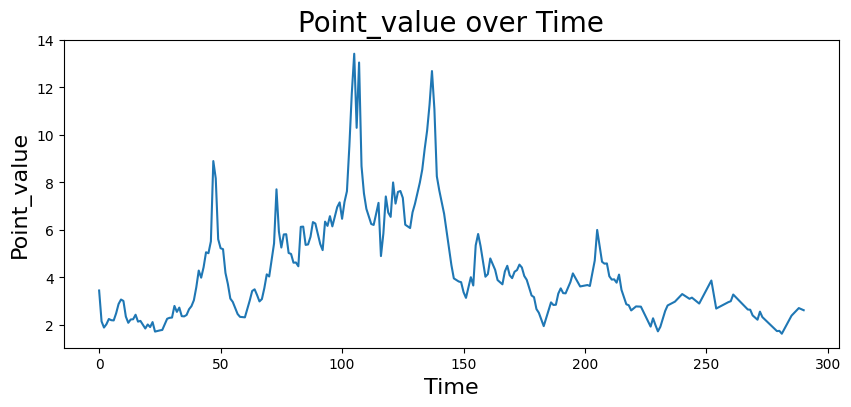

In [118]:
plt.figure(figsize=(10,4))
plt.plot(df_sample.point_value)
plt.title('Point_value over Time', fontsize=20)
plt.ylabel('Point_value', fontsize=16)
plt.xlabel('Time', fontsize=16)
#for i in df_sample.point_timestamp:
 #   plt.axvline(pd.to_datetime(i), color='y', linestyle='-', alpha=0.2)

In [109]:
#Seasonality Test
def check_seasonality(df_data):
    adf_result = adfuller(df_data['point_value'])
    p_value = adf_result[1]

    if p_value < 0.05:
        print('The time series data is likely seasonal.')
        adf_seasonal = 1
    else:
        print('The time series data is likely not seasonal.')
        adf_seasonal = 0

    print(adf_seasonal)

    kpss_stat, p_value, lags, critical_values = kpss(df_data, regression='c')

    # Interpret the results
    print(f'KPSS Statistic: {kpss_stat}')
    print(f'p-value: {p_value}')
    print(f'Critical values: {critical_values}')

    if p_value < 0.05:
        print('Reject the null hypothesis. The data has seasonality.')
        kpss_seasoanlity = 1
    else:
        print('Fail to reject the null hypothesis. The data does not have seasonality.')
        kpss_seasoanlity = 0

    if adf_seasonal == 1 and kpss_seasoanlity == 1:
        print('The given Time Series data is seasonal')
        return 1
        
    else:
        return 0


In [110]:
#stationarity test
def check_stationarity(df_data):
    result = adfuller(df_data['point_value'])
    # print the test statistics and p-value
    print(f'Test Statistic: {result[0]}')
    print(f'p-value: {result[1]}')

    # interpret the test results
    if result[1] > 0.05:
        adf_stationarity = 0
        print('The data is not stationary.')
    else:
        adf_stationarity = 1
        print('The data is stationary.')
    
    result_kpss = kpss(df_data['point_value'])

    # print the KPSS test statistics and p-value
    print('\nKPSS Test:')
    print(f'Test Statistic: {result_kpss[0]}')
    print(f'p-value: {result_kpss[1]}')
    # interpret the KPSS test results
    if result_kpss[1] < 0.05:
        kpss_stationarity = 0
        print('The data is not stationary according to the KPSS test.')
    else:
        kpss_stationarity = 1
        print('The data is stationary according to the KPSS test.')
    
    if kpss_stationarity == 1 or adf_stationarity == 1:
        return 1
    else:
        return 0

In [111]:
check_seasonality(df_sample)

The time series data is likely not seasonal.
0
KPSS Statistic: 0.42757008598227164
p-value: 0.06527151466281395
Critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
Fail to reject the null hypothesis. The data does not have seasonality.


0

In [107]:
check_stationarity(df_sample)

Test Statistic: -2.2221214974090127
p-value: 0.1983148116706518
The data is not stationary.

KPSS Test:
Test Statistic: 0.42757008598227164
p-value: 0.06527151466281395
The data is stationary according to the KPSS test.


1

In [120]:
def call_sarima(data):

  ts_log, ts = transform(data['point_value'])
  acf_vals, confint = sm.tsa.acf(data['point_value'], nlags=50, alpha=0.05)
  pacf_vals = sm.tsa.pacf(data['point_value'], nlags=50)

# find the lags where the ACF or PACF values are above the significance threshold
  acf_lags = [(i+1) for i in range(len(acf_vals)) if abs(acf_vals[i]) >= confint[i, 1]]
  pacf_lags = [(i+1) for i in range(len(pacf_vals)) if abs(pacf_vals[i]) >= confint[i, 1]]

  print(acf_lags)
  print(pacf_lags)

  d = 0
  df_diff = data.diff().dropna()
  while True:
      result = adfuller(df_diff['point_value'].diff().dropna())
      pvalue = result[1]
      if pvalue < 0.05:
          break
      d += 1
      df_diff = df_diff.diff().dropna()

  model = sm.tsa.statespace.SARIMAX(ts, order=(pacf_lags, d, acf_lags), seasonal_order=(pacf_lags, d, acf_lags,12))
  result = model.fit()
  print(result.summary())

In [ ]:
call_sarima(df_sample)

In [ ]:
from statsmodels.tsa.arima_model import ARIMA

data = df_sample

from statsmodels.tsa.stattools import adfuller

result = adfuller(data['point_value'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
    

data_diff = data.diff()

result = adfuller(data_diff['point_value'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
    
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(data_diff)
plot_pacf(data_diff)

# Fit the ARIMA model
model = ARIMA(data, order=(1,1,1))
model_fit = model.fit()

predictions = model_fit.predict()

plt.plot(data)
plt.plot(predictions, color='red')
plt.title('ARIMA Predictions')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

In [ ]:
freq = pd.infer_freq(data.index)
    print(freq)
    if(freq == 'M' or freq == 'MS'):
        tscv = TimeSeriesSplit(n_splits=5)
        for train_index, test_index in tscv.split(data):
            X_train, X_test = data.iloc[train_index], data.iloc[test_index]
            y_train, y_test = data.iloc[train_index]['point_value'], data.iloc[test_index]['point_value']

            # Create an XGBoost model
            xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)

            # Fit the model to the training data
            xgb_model.fit(X_train, y_train)

            # Use the model to make predictions on the test data
            y_pred = xgb_model.predict(X_test)

            # Calculate the mean squared error of the model's predictions
            mse = mean_squared_error(y_test, y_pred)
            print("Mean Squared Error:", mse)
            plt.figure()
            plt.plot(X_train.index, y_train, label='Train')
            plt.plot(X_test.index, y_test, label='Test')
            plt.plot(X_test.index, y_pred, label='Predicted')
            plt.legend()
            plt.show()
    
    if(freq == 'D'):
        daily_data = daily_data.resample('M').mean()

        # Split the data into training and testing sets using time series cross-validation
        tscv = TimeSeriesSplit(n_splits=5)
        for fold, (train_index, test_index) in enumerate(tscv.split(daily_data)):
            X_train, X_test = daily_data.iloc[train_index], daily_data.iloc[test_index]
            y_train, y_test = daily_data.iloc[train_index]['point_value'], daily_data.iloc[test_index]['point_value']

            # Create an XGBoost model
            xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)

            # Fit the model to the training data
            xgb_model.fit(X_train, y_train)

            # Use the model to make predictions on the test data
            y_pred = xgb_model.predict(X_test)

            # Calculate the mean squared error of the model's predictions
            mse = mean_squared_error(y_test, y_pred)
            print("Fold {} Mean Squared Error: {}".format(fold+1, mse))

            # Plot the model's predictions
            plt.figure()
            plt.plot(X_train.index, y_train, label='Train')
            plt.plot(X_test.index, y_test, label='Test')
            plt.plot(X_test.index, y_pred, label='Predicted')
            plt.legend()
            plt.show()

        return "XG_BOOST"